# Hyperspy Tutorial

## EELS analysis of perovskite oxides

This tutorial shows the various functionalities in HyperSpy which is used to analyse Electron Energy Loss Spectroscopy data, using EELS datasets from perovskite oxide heterostructure.

It assumes some knowledge on how to use HyperSpy, like loading datasets and how the basic signals work.

This notebook requires:

HyperSpy 1.1 

## Author

7/6/2016 Magnus Nord - Developed for HyperSpy workshop at Scandem conference 2016

## Changes

* 3/8/2016 Updated for HyperSpy 1.1. Added note about Gatan Digital Micrograph GOS.

## Table of contents

1. <a href='#spec_and_data'> Specimen & Data</a>
2. <a href='#simple_quant'> Simple quantification</a>
3. <a href='#curve_fitting_quant'> Curve fitting quantification</a>
4. <a href='#fine_structure_analysis'> Fine structure analysis</a>
5. <a href='#fine_structure_ok'> Fine structure oxygen-K edge</a>

# <a id='spec_and_data'></a>1. Specimen & Data

This notebook was used for the HyperSpy workshop at the Norwegian University of Science and Technology for the Scandem 2016 conference, 7 June 2016.

The data was acquired on a Jeol ARM200cF using a Gatan Quantum ER with DualEELS capabilities.

The data itself is from La0.7Sr0.3MnO3 thin films deposited on SrTiO3. In the Fine Structure example parts of the film has been exposed to a very long electron beam exposure, inducing oxygen vacancies.

The datasets has been binned to reduce the file size and processing time.

# <a id='simple_quant'></a> 2. Simple quantification


Firstly we use some IPython magic to import the right plotting libraries, then import HyperSpy

In [1]:
%matplotlib nbagg

In [2]:
import hyperspy.api as hs

First we take a look at an EELS line scan across an La0.7Sr0.3MnO3/SrTiO3 thin film. The core loss data has several peaks: Ti-L23, O-K, Mn-L23 and La-M54. We can navigate the line scan using the navigation window, and by moving the red line.

In [110]:
s = hs.load("datasets/LSMO_STO_linescan.hdf5")

<IPython.core.display.Javascript object>


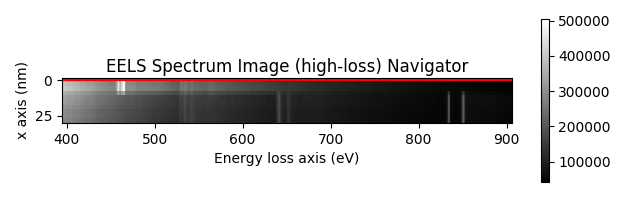

<IPython.core.display.Javascript object>


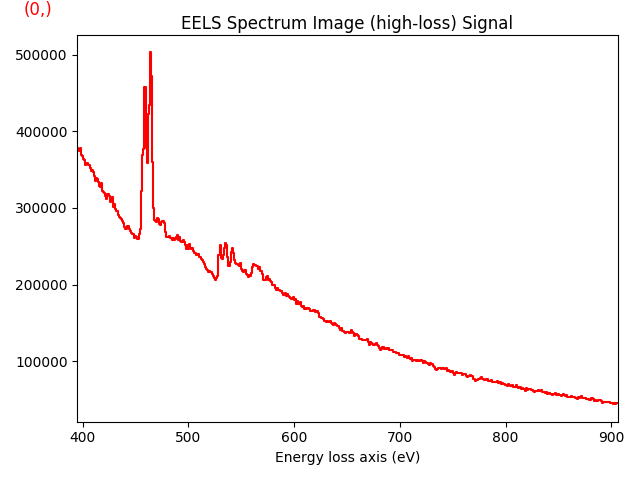

In [111]:
s.plot()

Now we can quantifiy the first edge (Ti-L23, 460 eV, 0-10 nm). Firstly by removing the background, then integrating the Ti-L23 edge. The remove_background box can disappear (known bug) when using the qt4 toolkit. If it does run the s.remove_background() command again of use ipywidgets GUI instead.

<IPython.core.display.Javascript object>


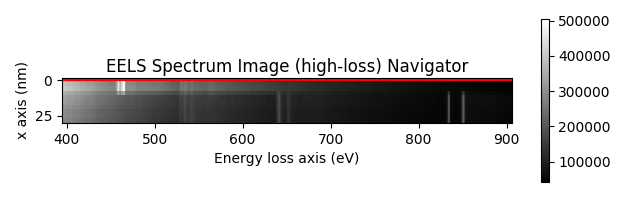

<IPython.core.display.Javascript object>


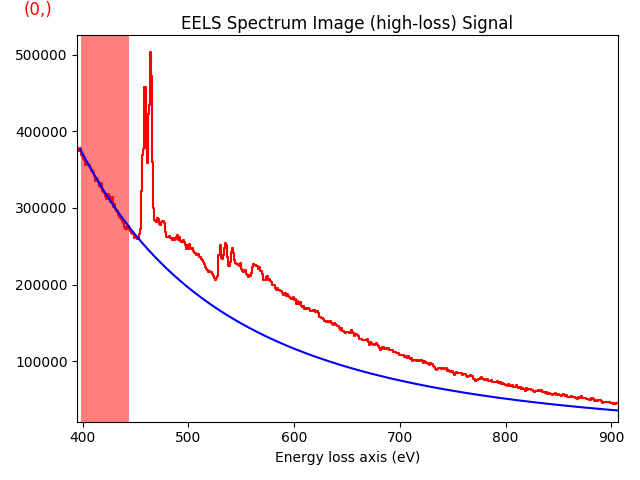

In [112]:
s.remove_background()

To integrate the Ti-L32 edge interactively we can use a region of interest:

<IPython.core.display.Javascript object>


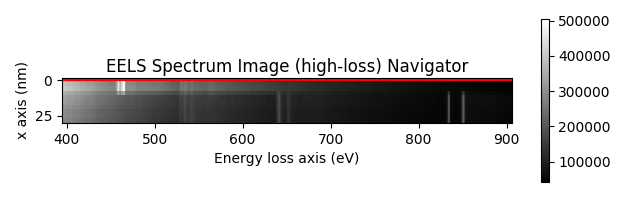

<IPython.core.display.Javascript object>


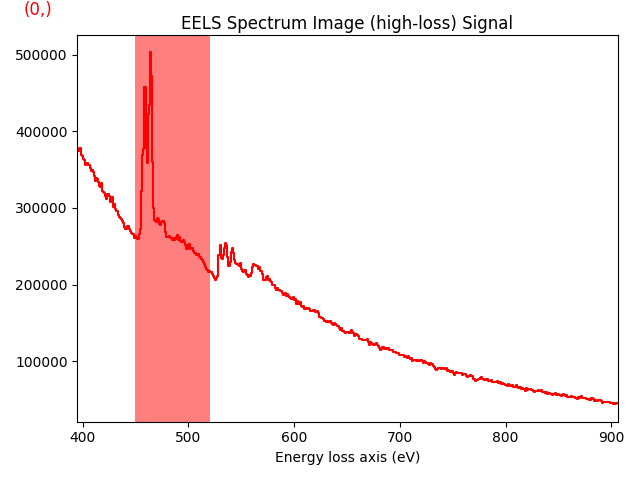

In [20]:
roi = hs.roi.SpanROI(left=450, right=600)
s.plot()
roi.add_widget(s, axes=["Energy loss"])

Finally, to integrate the signal in the selected ROI:

In [22]:
s_ti = s.isig[roi].integrate1D(axis="Energy loss")

<IPython.core.display.Javascript object>


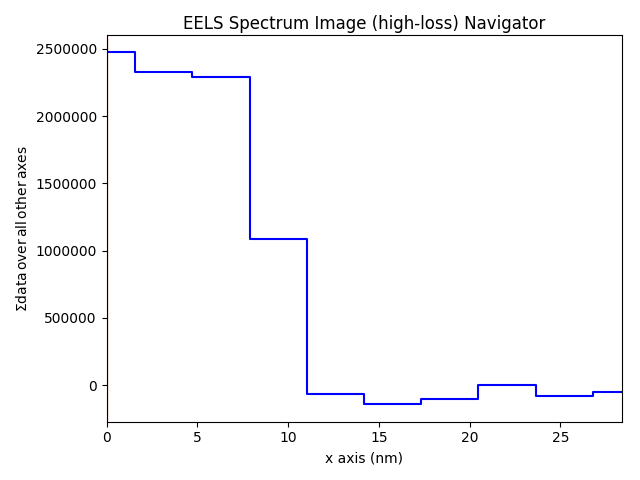

In [25]:
s_ti.plot()

Notice that we can also perform the same operations in one single line if interactivity is not required:

In [26]:
s = hs.load("datasets/LSMO_STO_linescan.hdf5")

In [27]:
s_ti = s.remove_background(signal_range=(405.,448.)).isig[448.:480.].integrate1D(axis="Energy loss")

<IPython.core.display.Javascript object>


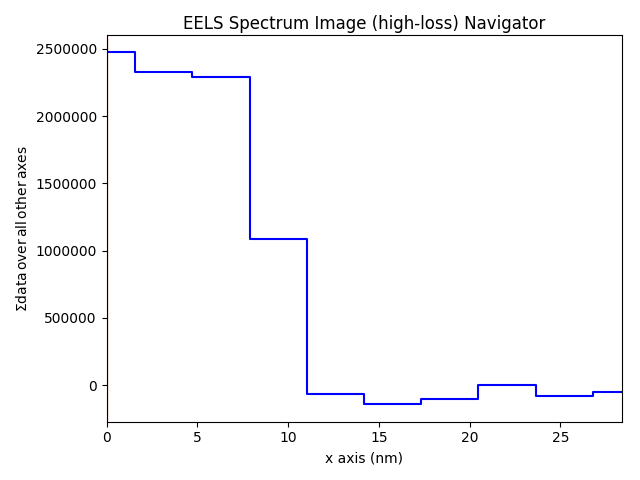

In [28]:
s_ti.plot()

# <a id='curve_fitting_quant'></a> 3. Curve fitting quantification

Now, lets do some more advanced quantification using HyperSpy's extensive modelling framework. Firstly we load the low loss and core loss spectra.

Firstly we'll have to tell HyperSpy where to find the Digital Micrograph Hartree-Slater cross section files, since they are not included in HyperSpy. Go to the "EELS" tab, then set "GOS directory" to the "H-S GOS Tables" folder. Note that unfortunately this requires a license of Gatan Digital Micrograph.

If you don't have Digital Micrograph you can still perform curve fitting of K and L edges using Ray Egerton's Hydrogenic cross-sections which are included in HyperSpy

In [29]:
hs.preferences.gui()

In [30]:
s_ll = hs.load("datasets/LSMO_STO_linescan_low_loss.hdf5")

In [31]:
s = hs.load("datasets/LSMO_STO_linescan.hdf5")

Here, the metadata has been populated with some of the experimental parameters:

In [32]:
s.metadata

├── Acquisition_instrument
│   └── TEM
│       ├── Detector
│       │   └── EELS
│       │       └── collection_angle = 33.100000000000001
│       ├── beam_energy = 200.0
│       ├── convergence_angle = 27.100000000000001
│       └── dwell_time = 0.49990557338919173
├── General
│   ├── original_filename = LSMO_STO_linescan.dm3
│   └── title = EELS Spectrum Image (high-loss)
└── Signal
    ├── binned = True
    ├── signal_origin = 
    └── signal_type = EELS

Firstly, we make sure the energy scale is properly aligned by using the zero loss peak in the low loss spectrum. The subpixel argument interpolates the data, so we get sub-pixel alignment. Using the also_align argument, we can also apply the alignment on a another signal. For example when using dualEELS, where both the low loss and core loss is acquired quasi-simultaneously. Note the other signals must have the same navigation shape as the low loss signals.

In [33]:
s_ll.align_zero_loss_peak(subpixel=True, also_align=[s])


Initial ZLP position statistics
-------------------------------
Summary statistics
------------------
mean:	-1.000
std:	0.000

min:	-1.000
Q1:	-1.000
median:	-1.000
Q3:	-1.000
max:	-1.000


We have to add the elements which is present in the sample to `s`

In [34]:
s.add_elements(('Mn','O','Ti','La'))

Then we make a model out of the core loss spectrum. The low loss spectrum is convolved with the model, which means plural scattering is automatically taken into account. In addition this leads to better fits.

**NOTE:** creating this model requires using the GOS files from Gatan Digital Micrograph. If you don't have these files only K and L edges can be created using Hydrogenic cross sections. If you do have them but HyperSpy can't find them in the default location, you can specify the location using `hs.preferences.gui()`.

In [35]:
m = s.create_model(ll=s_ll)

The model new consist of many different EELSCLEdge components, including a component for the plasmon background

In [36]:
m.components

   # |      Attribute Name |      Component Name |      Component Type
---- | ------------------- | ------------------- | -------------------
   0 |            PowerLaw |            PowerLaw |            PowerLaw
   1 |               Ti_L3 |               Ti_L3 |          EELSCLEdge
   2 |               Ti_L2 |               Ti_L2 |          EELSCLEdge
   3 |               Ti_L1 |               Ti_L1 |          EELSCLEdge
   4 |                 O_K |                 O_K |          EELSCLEdge
   5 |               Mn_L3 |               Mn_L3 |          EELSCLEdge
   6 |               Mn_L2 |               Mn_L2 |          EELSCLEdge
   7 |               Mn_L1 |               Mn_L1 |          EELSCLEdge
   8 |               La_M5 |               La_M5 |          EELSCLEdge
   9 |               La_M4 |               La_M4 |          EELSCLEdge

We can fit the model to the experimental data by using the `multifit` function, with the `smart` fitting. Which is fits in a way optimized for EELS data, by fitting from the lowest to the highest energy losses.

In [37]:
m.multifit(kind='smart')

<IPython.core.display.Javascript object>


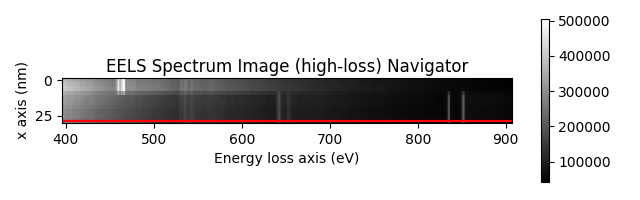

<IPython.core.display.Javascript object>


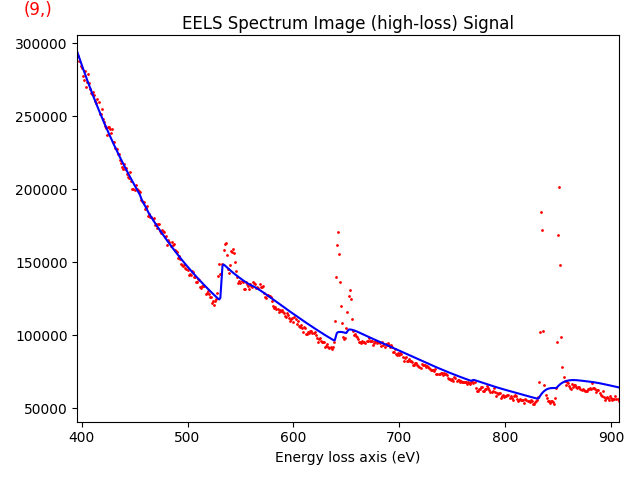

In [38]:
m.plot()

We can check the error of the fitting

In [39]:
edges = ("Ti_L3", "La_M5", "Mn_L3","O_K")

<IPython.core.display.Javascript object>


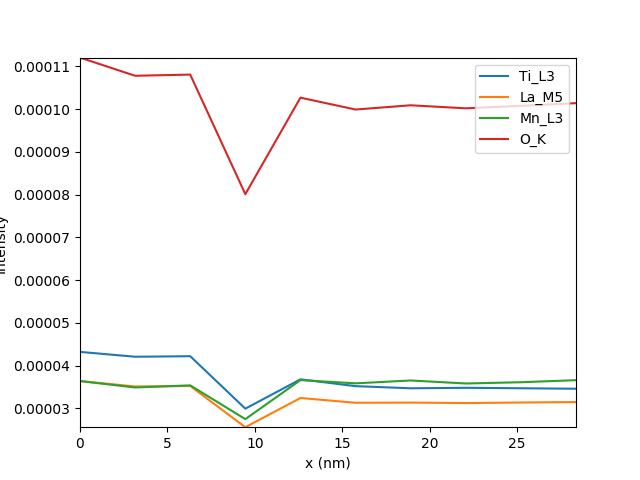

In [40]:
hs.plot.plot_spectra([m[edge].intensity.as_signal("std") for edge in edges], legend=edges)

This fitted mostly ok, but it is still not very good. Firstly we can move the Hartree-Slater onsets interactively

<IPython.core.display.Javascript object>


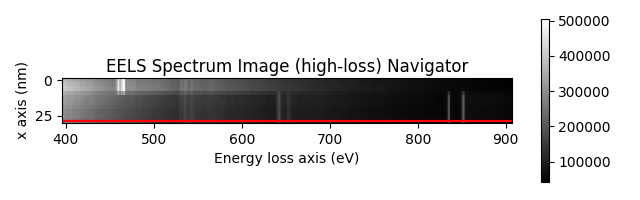

<IPython.core.display.Javascript object>


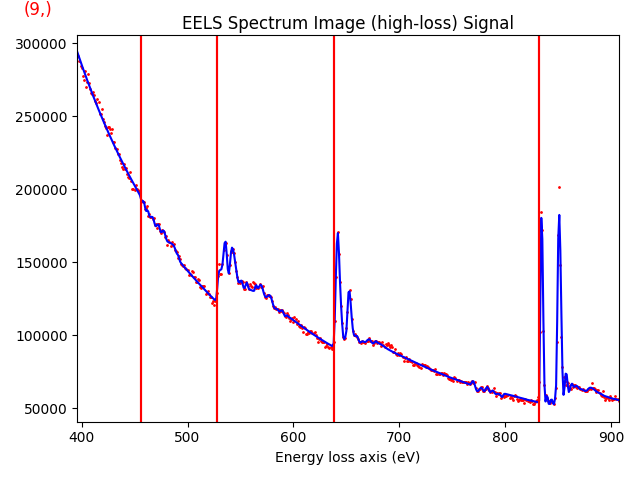

In [41]:
m.plot()
m.enable_adjust_position()

Or manually, by directly changing the parameters within the Hartree-Slater edges. The parameter is called onset_energy

In [42]:
m.components.O_K.onset_energy.value = 528

However, to change it for all the probe positions we have to use assign_current_value_to_all()

In [43]:
m.components.O_K.onset_energy.assign_current_value_to_all()

We repeat this for the Manganese edges. Since this is an L-edge, there are 3 different ones. However, we only have to set the Mn-L3: the L2 and L1 is a set to an energy relative to the L3.

In [44]:
m.components.Mn_L3.onset_energy.value

640.0

In [45]:
m.components.Mn_L2.onset_energy.value

651.0

In [46]:
m.components.Mn_L3.onset_energy.value = 638.5

In [47]:
m.components.Mn_L2.onset_energy.value 

649.5

In [48]:
m.components.Mn_L3.onset_energy.assign_current_value_to_all()

This is due to the fine structure not currently taken into account by the model. To get a good fit, we can either not fit to the fine structure regions, or model them somehow.
The easiest way is defining certain regions as fine structure:

In [49]:
m.enable_fine_structure()

This will produce a much better fit, but will be much slower (~2 minutes).

In [50]:
m.multifit(kind='smart')

/home/fjd29/Python/hyperspy3/hyperspy/model.py:1094: RuntimeWarning: invalid value encountered in sqrt
  self.p_std = np.sqrt(np.diag(pcov))


Now the fit is much better, due to the model taking into account the fine structure.

<IPython.core.display.Javascript object>


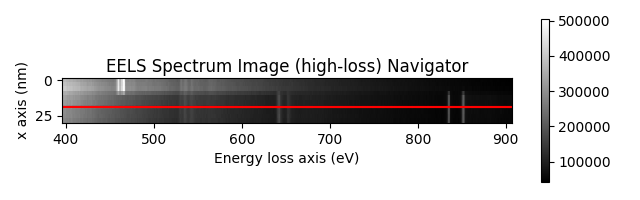

<IPython.core.display.Javascript object>


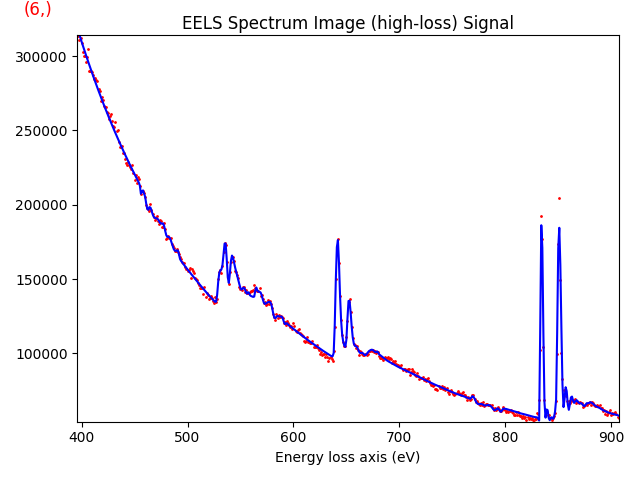

In [51]:
m.plot()

Now we can can have a look at the relative intensity from the individual EELS-edges using plot_spectra

In [52]:
edges = ("Ti_L3", "La_M5", "Mn_L3","O_K")

<IPython.core.display.Javascript object>


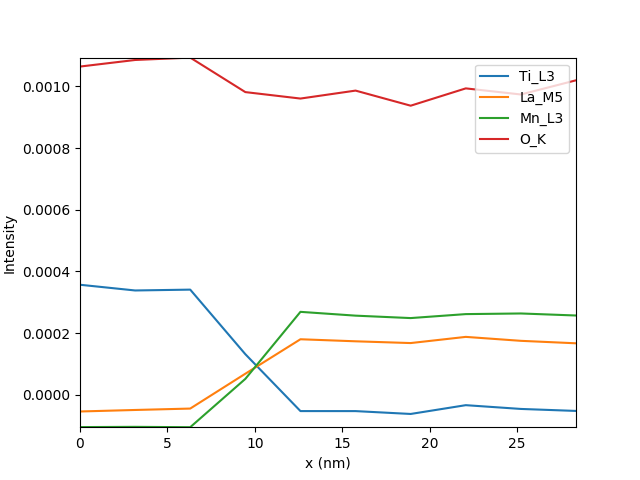

In [53]:
hs.plot.plot_spectra([m[edge].intensity.as_signal() for edge in edges], legend=edges)

While the fitting looks nicer, we can clearly improve this. Firstly the intensities are negative where it should be zero. Secondly, the fine structure regions can be fine tuned. Especially the Mn-L1 fine structure window can be reduced

In [54]:
m.components.Mn_L1.fine_structure_width = 15

To avoid the negative values we use bounded fitting, where we can constrain the parameter values between certain values. The bmin and bmax properties in the parameters are used for this.

In [55]:
m.components.Mn_L3.intensity.bmin = 0.0

In [56]:
m.components.La_M5.intensity.bmin = 0.0

In [57]:
m.components.Ti_L3.intensity.bmin = 0.0

In [58]:
m.components.O_K.intensity.bmin = 0.0

In [61]:
m.multifit(fitter="leastsq", kind='smart', bounded=True)

<IPython.core.display.Javascript object>


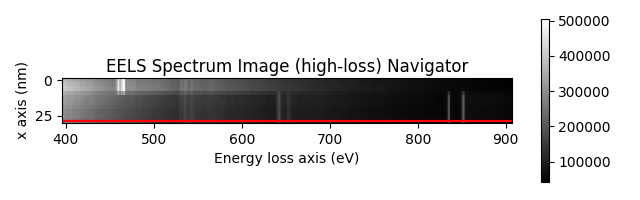

<IPython.core.display.Javascript object>


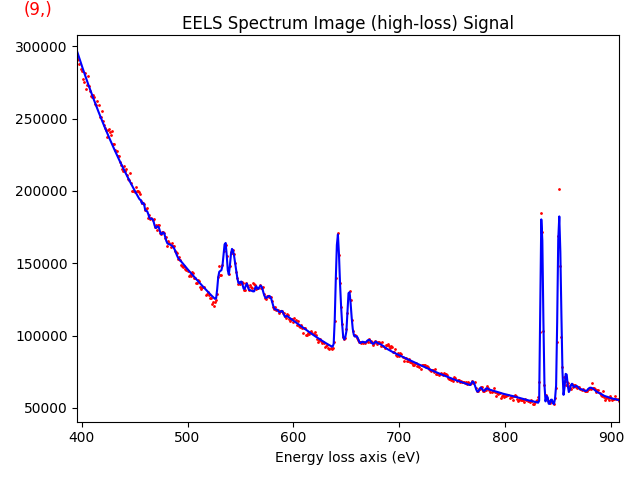

In [62]:
m.plot()

<IPython.core.display.Javascript object>


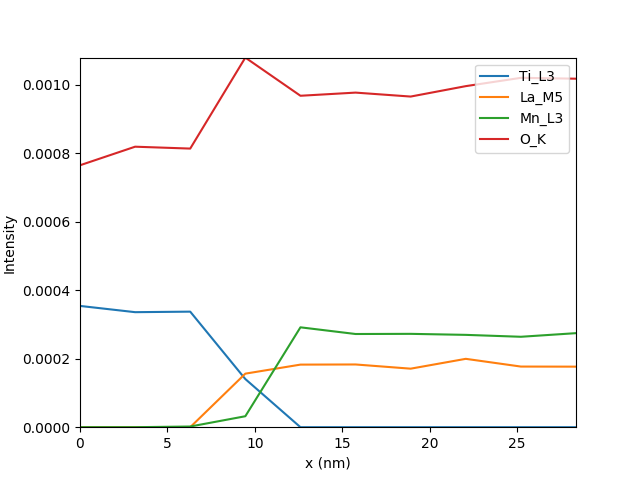

In [63]:
hs.plot.plot_spectra([m[edge].intensity.as_signal() for edge in edges], legend=edges)

# <a id='fine_structure_analysis'></a> 4. Fine structure analysis

Here we take a look at a linescan from a La0.7Sr0.3MnO3 thin film, where parts of the film has been bombarded with the electron beam for an extended time.

In [64]:
s = hs.load("datasets/LSMO_linescan.hdf5")

Using the moving the red line in the there is clearly something going on in the middle on both the oxygen and the manganese edges. In addition, there are some thickness changes during the line scan.

<IPython.core.display.Javascript object>


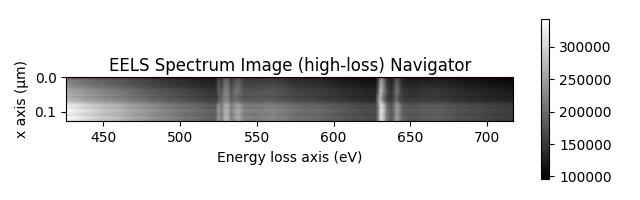

<IPython.core.display.Javascript object>


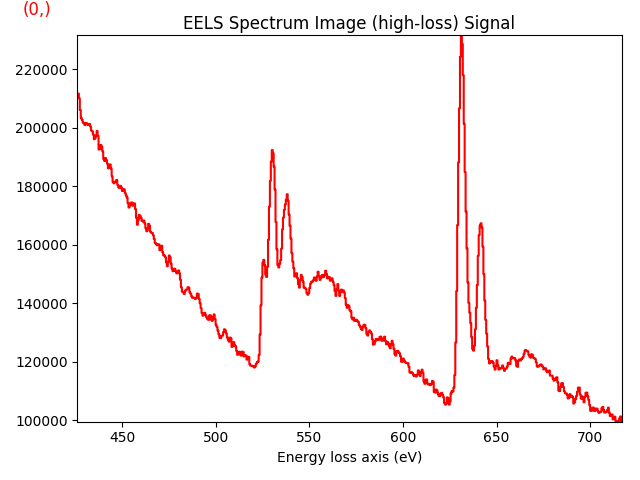

In [65]:
s.plot()

Using the low loss signal, we make sure the energy scale is properly calibrated

In [66]:
s_ll = hs.load("datasets/LSMO_linescan_low_loss.hdf5")

<IPython.core.display.Javascript object>


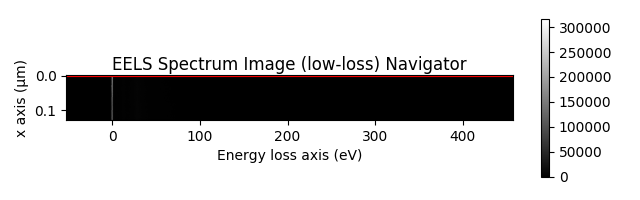

<IPython.core.display.Javascript object>


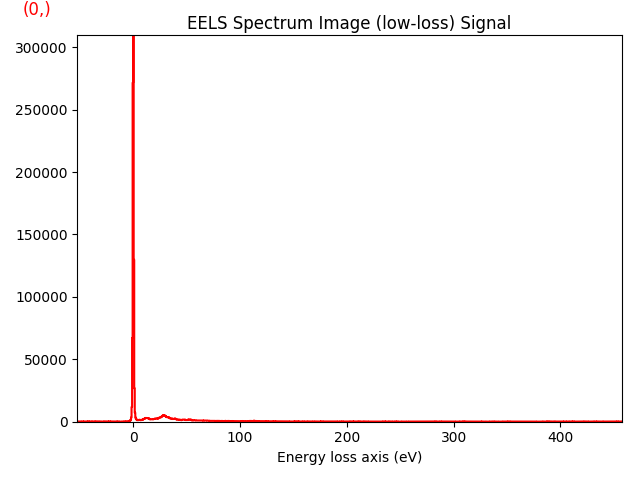

In [67]:
s_ll.plot()

The zero loss peak is not well aligned at 0 eV energy loss, so we should align it and the core loss

In [68]:
s_ll.align_zero_loss_peak(also_align=[s])


Initial ZLP position statistics
-------------------------------
Summary statistics
------------------
mean:	3.225
std:	0.249

min:	3.000
Q1:	3.000
median:	3.000
Q3:	3.500
max:	3.500


Now the zero loss peak has been shifted to 0 energy loss, and likewise the core loss spectrum `s` has also been aligned

<IPython.core.display.Javascript object>


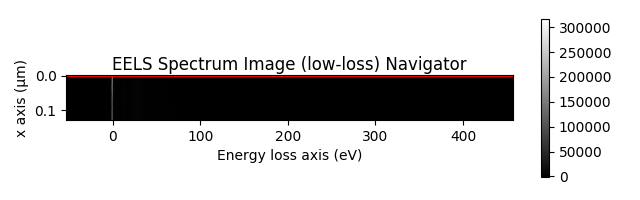

<IPython.core.display.Javascript object>


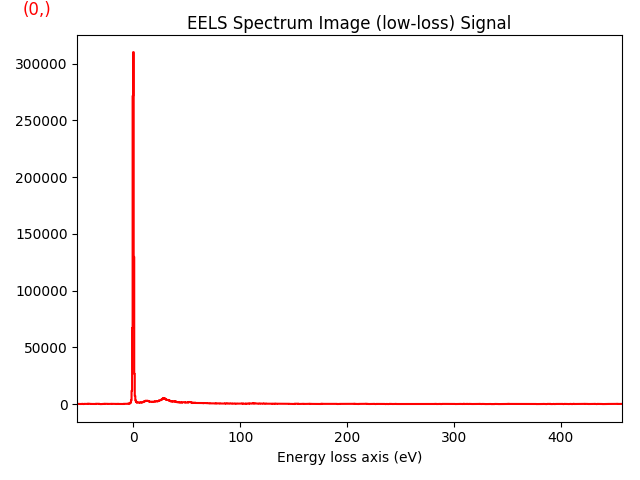

In [69]:
s_ll.plot()

We can also calculate the relative thickness using the low loss. We'll have to specify the end of the zero loss beam, which for cold field emissions guns 3.0 eV seems to work well.

In [70]:
s_thickness = s_ll.estimate_thickness(threshold=3.0)

This gives the relative thickness and, as expected, there is an increase towards the end of the line scan

<IPython.core.display.Javascript object>


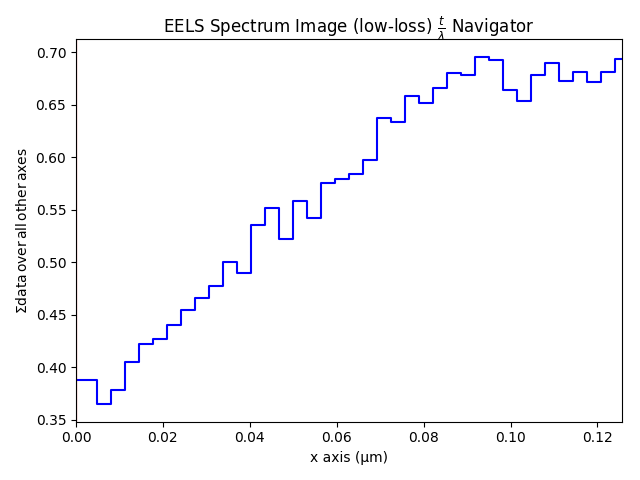

In [71]:
s_thickness.plot()

# <a id='fine_structure_ok'></a> 5. Fine structure: oxygen K-edge
Lets take a closer look at the oxygen-K edge, firstly by removing the plasmon background, then cropping the spectrum to only include the oxygen-K edge. Note: this will overwrite the `s` spectrum with the cropped one. 

<IPython.core.display.Javascript object>


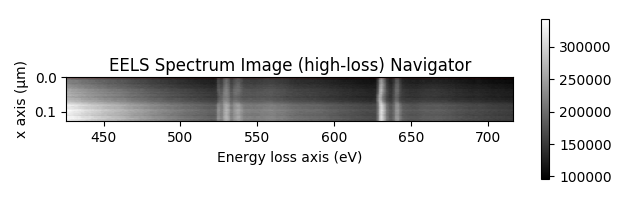

<IPython.core.display.Javascript object>


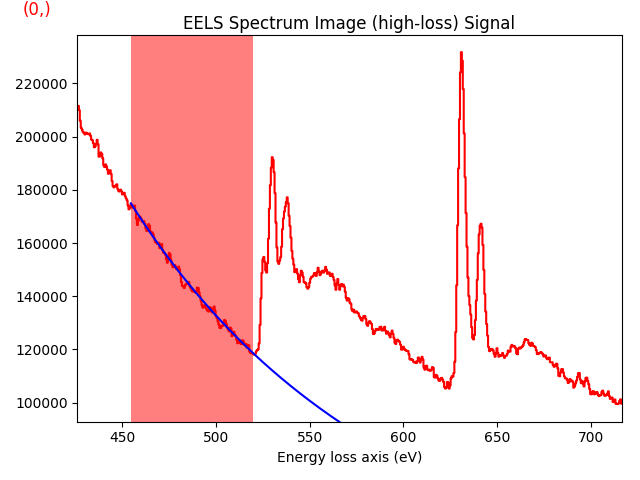

<IPython.core.display.Javascript object>


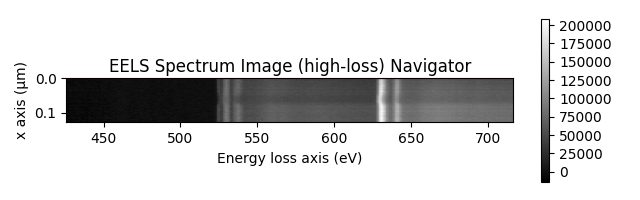

<IPython.core.display.Javascript object>


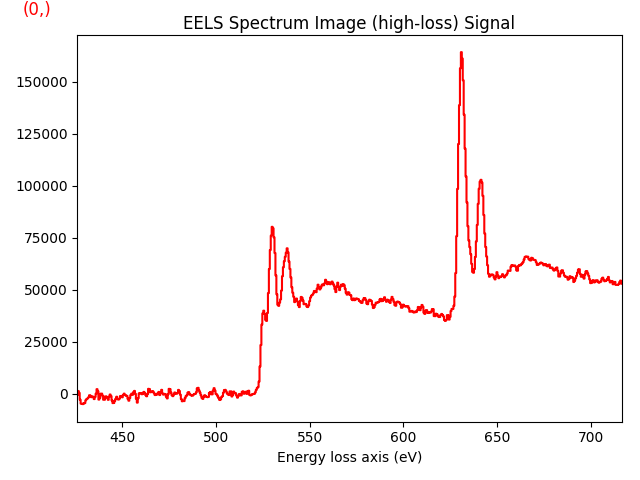

In [73]:
s.remove_background()

This makes it much easier to compare the different positions. Pressing 'e' with the spectrum window highlighted gives a second spectrum picker, which can be moved independently of the first one

We can then do Fourier ratio deconvolution to remove the effects of plural scattering

In [74]:
s_deconvolved = s.fourier_ratio_deconvolution(s_ll)

<IPython.core.display.Javascript object>


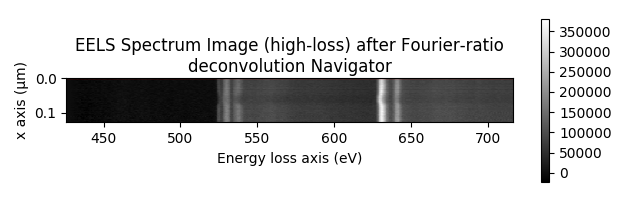

<IPython.core.display.Javascript object>


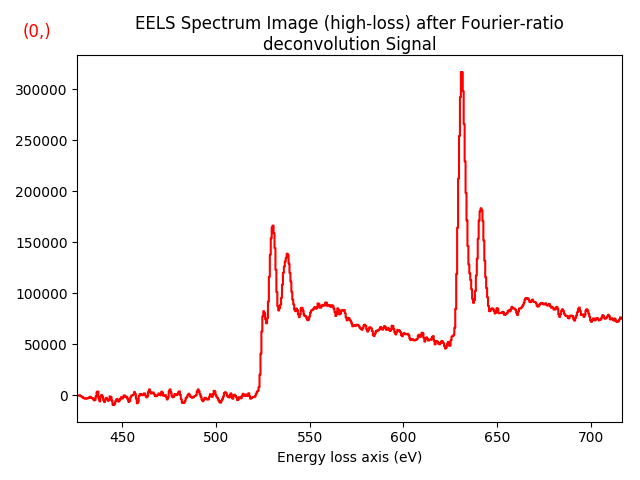

In [75]:
s_deconvolved.plot()

### Fine structure modelling

Having had a qualitatively look at the data, we can try to quantify some of these changes. We do this by making making a model of the oxygen-K edge signal. As we've already removed the background, we set `auto_background=False`. In addition, since we haven't added any elements to the signal, we got no ionization edges.

In [76]:
m = s.create_model(ll=s_ll, auto_background=False)

So currently, the model does not contain any components

In [77]:
m.components

   # |      Attribute Name |      Component Name |      Component Type
---- | ------------------- | ------------------- | -------------------

We can try to model some of the fine structure with Gaussians

In [79]:
g1 = hs.model.components1D.Gaussian()

In [80]:
m.append(g1)

This added the gaussian component to the model

In [81]:
m.components

   # |      Attribute Name |      Component Name |      Component Type
---- | ------------------- | ------------------- | -------------------
   0 |            Gaussian |            Gaussian |            Gaussian

Then we can fit this Gaussian to the largest of the O-K peaks by dragging a span over the peak between 528 and 533 eV. Run it first with the "Only Current" option ticked, then run it without to fit the whole dataset

<IPython.core.display.Javascript object>


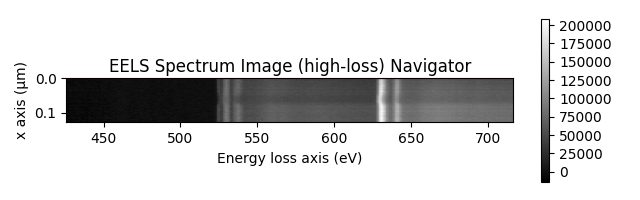

<IPython.core.display.Javascript object>


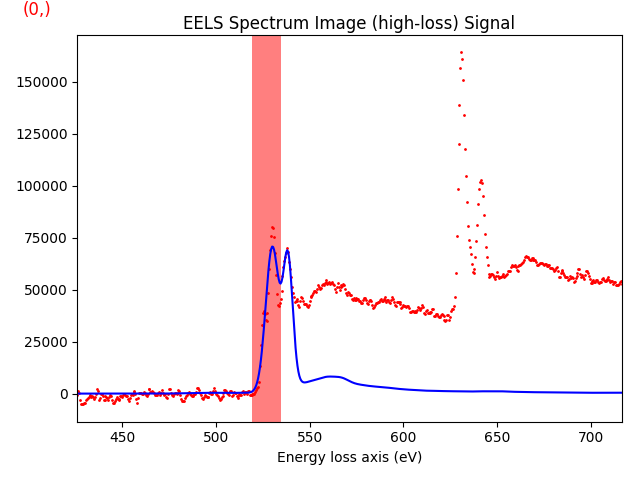

In [82]:
m.fit_component(g1)

Having fitted the Gaussian to the experimental data, we can plot how the Gaussian three parameters change over the line scan: A, sigma and centre. The A changes quite a bit, which is probably (among others) related to thickness changes. However, there are clear changes in the sigma parameter in the region with the electron beam damage

<IPython.core.display.Javascript object>


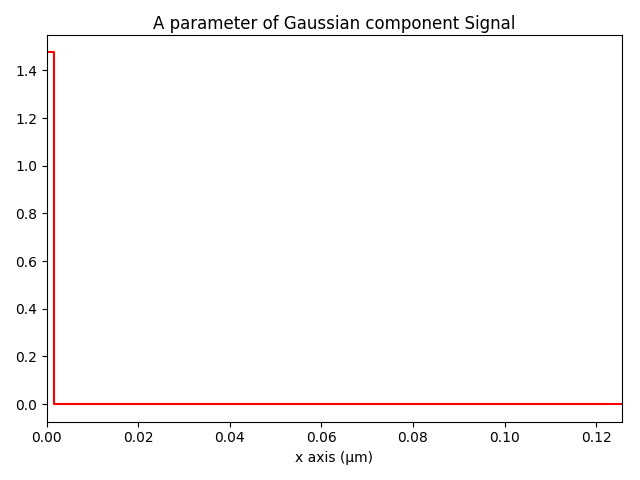

<IPython.core.display.Javascript object>


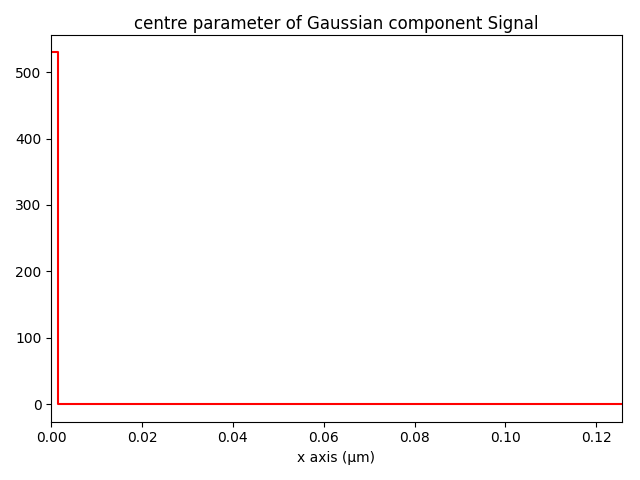

<IPython.core.display.Javascript object>


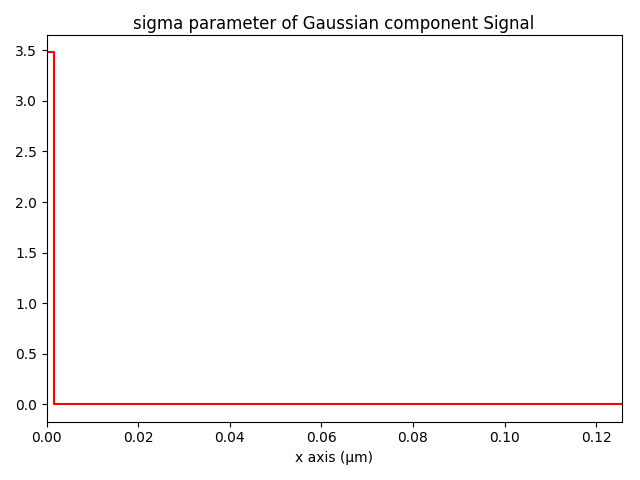

In [83]:
g1.plot()

Using the same method we can also fit the second largest peak between 535 and 541 eV. Using the signal_range argument we don't have to select the region using the GUI.

In [85]:
g2 = hs.model.components1D.Gaussian()

In [86]:
m.append(g2)

In [87]:
m.fit_component(g2, signal_range=(535.,541.), only_current=False)

<IPython.core.display.Javascript object>


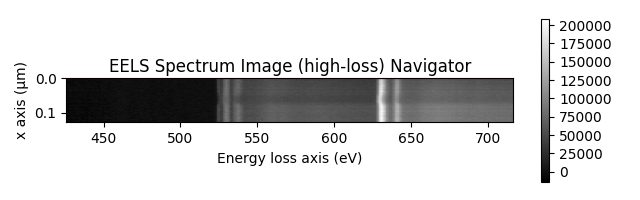

<IPython.core.display.Javascript object>


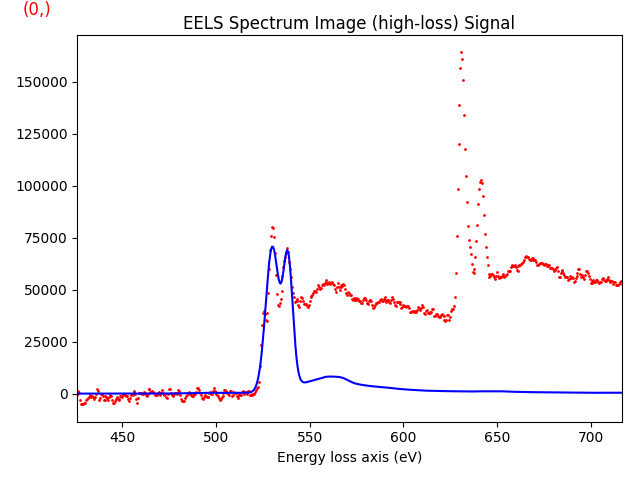

In [88]:
m.plot()

However, this time the final fit does not look very good. This is due to the two components being fitted independently of each other. We should fit both of them at the same time. Firstly, we have to set the `signal_range` which is where the model will fit to the experimental data. Here we select the region spanning the two major peaks (528-541 eV)

<IPython.core.display.Javascript object>


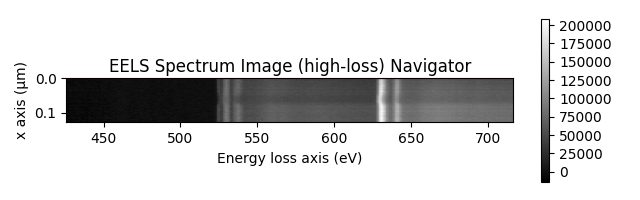

<IPython.core.display.Javascript object>


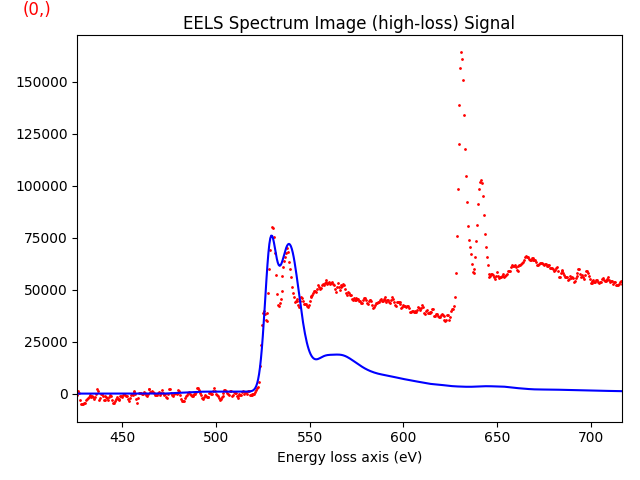

In [89]:
m.set_signal_range()

In [90]:
m.multifit()

After fitting, we reset the signal range so we can see the full range of the signal

In [91]:
m.reset_signal_range()

<IPython.core.display.Javascript object>


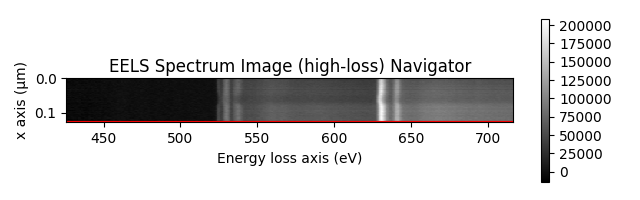

<IPython.core.display.Javascript object>


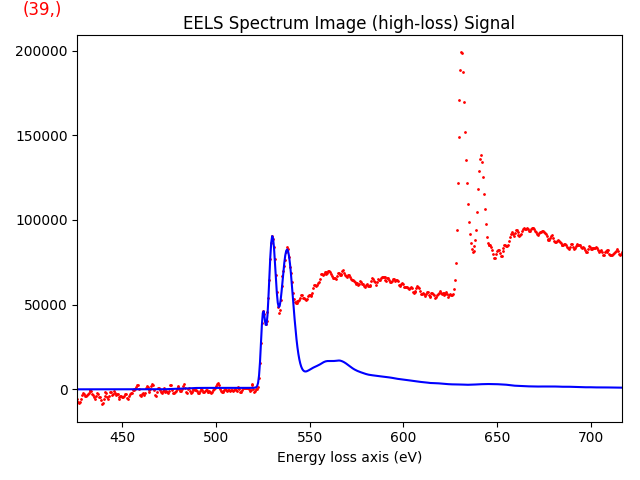

In [92]:
m.plot()

Lastly, we can fit the small "pre-peak" as well. First we "lock" the two Gaussian we have already fitted.

In [93]:
g1.set_parameters_not_free()

In [94]:
g2.set_parameters_not_free()

Then we add another Gaussian, and fit it using `fit_component` between 522 and 527 eV

In [95]:
g3 = hs.model.components1D.Gaussian()

In [96]:
m.append(g3)

In [97]:
m.fit_component(g3, signal_range=(522., 527.), only_current=False)

Then we set the signal range to cover all the three peaks, from 520 eV to 541 eV

In [98]:
m.set_signal_range(520.,541.)

And set the g1 and g2 components free

In [99]:
g1.set_parameters_free()

In [100]:
g2.set_parameters_free()

In [101]:
m.multifit()

This fits all the three components to the experimental data, which hopefully gives a good fit

In [102]:
m.reset_signal_range()

<IPython.core.display.Javascript object>


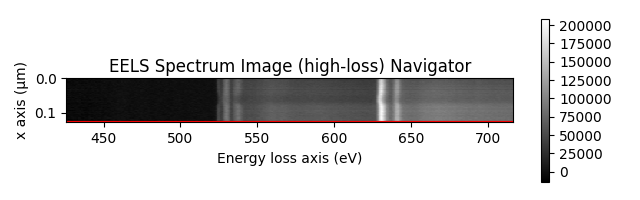

<IPython.core.display.Javascript object>


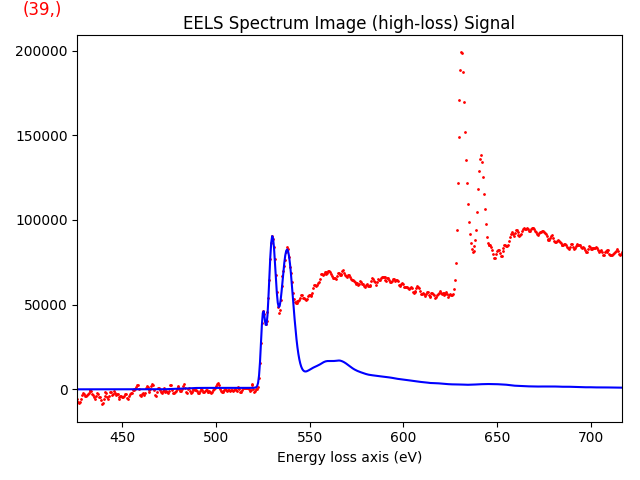

In [103]:
m.plot()

We can then compare the different parameters in the components

In [104]:
g1_g3_ratio = g1.A.as_signal()/g3.A.as_signal()

<IPython.core.display.Javascript object>


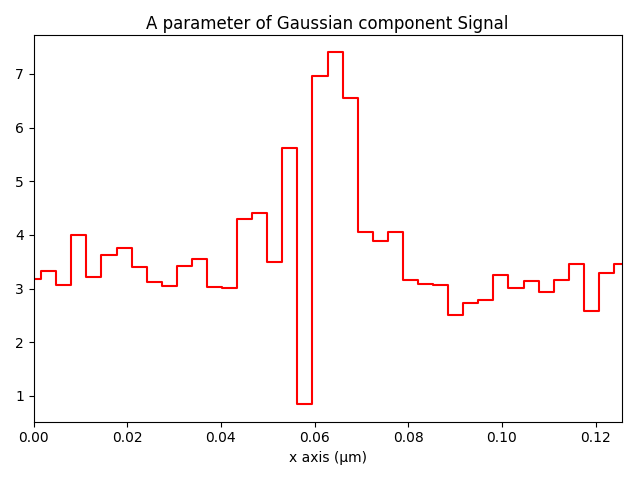

In [105]:
g1_g3_ratio.plot()

In [106]:
g1_g3_position = g1.centre.as_signal()-g3.centre.as_signal()

<IPython.core.display.Javascript object>


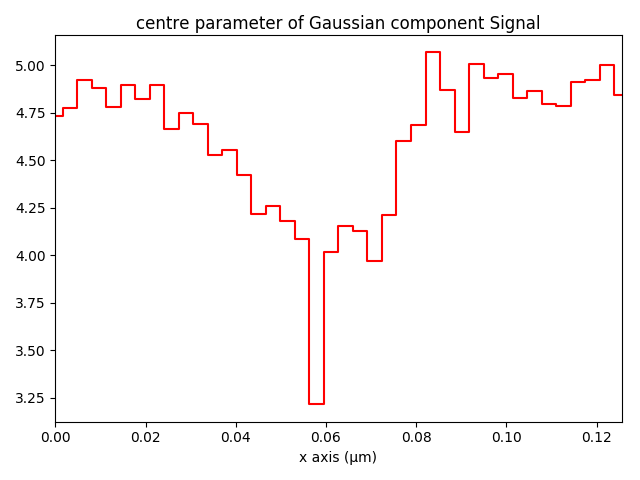

In [107]:
g1_g3_position.plot()

In [108]:
g1_g3_sigma = g1.sigma.as_signal()/g3.sigma.as_signal()

<IPython.core.display.Javascript object>


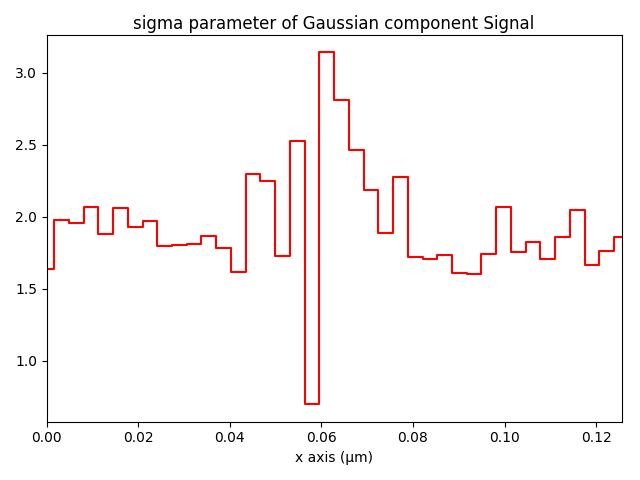

In [109]:
g1_g3_sigma.plot()

In all of the comparisons there are some large changes in the regions with beam damage. However, the values can vary a great deal. This is most likely due to the g1 fitted to the pre-peak is not so clearly defined in these regions. Leading to potentially bad fitting.